[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dominik-strutz/WoWED-volcano/blob/main/example_design_process.ipynb)

In [10]:
# MAKE SURE TO RUN THIS CELL FIRST
# this might take a minute or two
# This cell will install the necessary dependencies and import the necessary modules for the notebook to run in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    
if IN_COLAB:
    dependencies_installed = False

    if not dependencies_installed:
        ! rm -rf *
        ! git clone --quiet https://github.com/dominik-strutz/WoWVED tmp
        ! mv tmp/* .
        ! rm -rf tmp
        # only install the first 8 lines of the requirements file to only install the necessary dependencies
        ! head -8 requirements.txt > tmp.txt
        ! mv tmp.txt requirements.txt 
        ! pip install -q -r requirements.txt
        dependencies_installed = True
    from google.colab import output
    output.enable_custom_widget_manager()

In [11]:
# Importing the necessary modules
import time 
import numpy as np      

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('helpers/mplstyle.mplstyle')

In [12]:
# Importing the necessary helper functions
from helpers.volcano_data_helpers import (
    get_volcano_data,
    fetch_topography_data,
    construct_highly_opinionated_prior,
    choose_volcano,
    )

from helpers.plotting_helpers import (
    draw_bounding_box,
    plot_topography,
    plot_prior_model,
    plot_posterior_model,
    plot_design_space_dict,
    plot_design,
    plot_design_statistics
    )

# Volcano Data

The Smithsonian Institution's Global Volcanism Program (GVP) (Venzke, 2024) provides a comprehensive database of volcanic activity, including eruption histories, reports, and data. We use this to obtain basic information about any volcano by providing its name, such as its location, type, and eruption history. This information is used for several of the following steps.

In [13]:
defalut_volcano = 'Etna'
select_volcano = choose_volcano(defalut_volcano)

display(select_volcano)

Combobox(value='Etna', description='Choose volcano:', ensure_option=True, options=('Abu', 'Acamarachi', 'Acate…

In [14]:
##################### Choose the volcano ##################### 
VOLCANO_NAME = select_volcano.value
###################### Get the data ##  #######################
VOLCANO_DATA = get_volcano_data(VOLCANO_NAME)

################# Choose area of interest ####################
# you can define the bounding box manually or interactively
# the bounding box is defined either in terms of the extent in km
# or in terms of the min and max latitudes and longitudes

# BOUNDING_BOX = dict(
#     min_lon= VOLCANO_DATA['lon'] - 0.15, # in deg lon
#     max_lon= VOLCANO_DATA['lon'] + 0.15, # in deg lon
#     min_lat= VOLCANO_DATA['lat'] - 0.15, # in deg lat
#     max_lat= VOLCANO_DATA['lat'] + 0.15, # in deg lat
# )
BOUNDING_BOX = dict(
    extent_south = 20.0, # in km
    extent_north = 20.0, # in km
    extent_west  = 20.0, # in km
    extent_east  = 20.0, # in km
)
# the function below allows you to interactively choose the bounding box
# to change the bounding box, just click on the little square icon and draw a new bounding box
# NOTE: this will overwrite the bounding box you defined above
# NOTE: if you rerun this cell, you will have to redefine the bounding box
m, BOUNDING_BOX = draw_bounding_box(
    VOLCANO_DATA, BOUNDING_BOX,
)
display(m)

################# Choose the depth range ####################
# the depth range is defined in km below sea level
MAX_DEPTH = 10.0        # km below sea level

Map(center=[37.748, 14.999], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

# Topography

The volcano used in this example is Etna, a stratovolcano in Italy. By defining a bounding box around the volcano's location, we use the OpenTopography API to obtain a digital elevation model (DEM) of the volcano. In this example, we use the SRTM15Plus  (Tozer et al., 2019), which has a sufficient resolution for most volcano monitoring scenarios and unlike many other DEM's it includes bathymetric data. It is also possible to use a custom DEM, but this is often unnecessary.

In [15]:
try:
    with open('.opentopography.txt', 'r') as file:
        api_key = file.read()
except FileNotFoundError:
    api_key = 'demoapikeyot2022'
# This is a demo key which should work for a limited number of requests. If you want to use the API more frequently, or if the key stops working, you can get your own key (see https://opentopography.org/blog/introducing-api-keys-access-opentopography-global-datasets for more information).

# API key for the Open Topography API to fetch the digital elevation model
# API key is stored in a separate file .opentopography.txt to avoid accidentally sharing it on GitHub
SURFACE_DATA = fetch_topography_data(VOLCANO_DATA, BOUNDING_BOX, api_key=api_key)

Fetching topography data for SRTM15Plus between 37.56751 and 37.92804 latitude and 14.77253 and 15.22657 longitude
Data loaded from cache


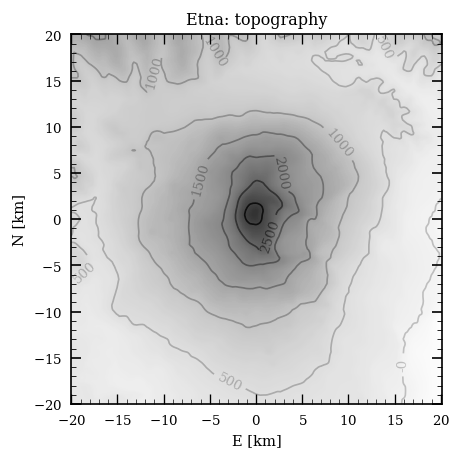

In [16]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=120)
plot_topography(ax, SURFACE_DATA['topography'])
ax.set_title(f'{VOLCANO_NAME}: topography')
plt.show()

# Prior Information

We can define a prior distribution for source locations based on the topographic information. We discretise the subsurface into a grid of cells, and a uniform prior distribution is assumed within each cell. For this example, we assume that the prior distribution is a Gaussian distribution with a standard deviation of 5 km in the Easting and Northing directions, and 8 km in the depth direction, centred the location of the volcano at a depth of 2 km. In addition, we assume that the prior distribution in each vertical column is proportional to the elevation at that point, which gives more weight to areas in which the volcano has a higher relative surface elevation. The result is, of course, a very simplified prior distribution, but it is easy to define, and since it is defined on a grid it is easy for any practitioner to adapt to a more complex distribution that takes a specific geological setting and other available information into account.

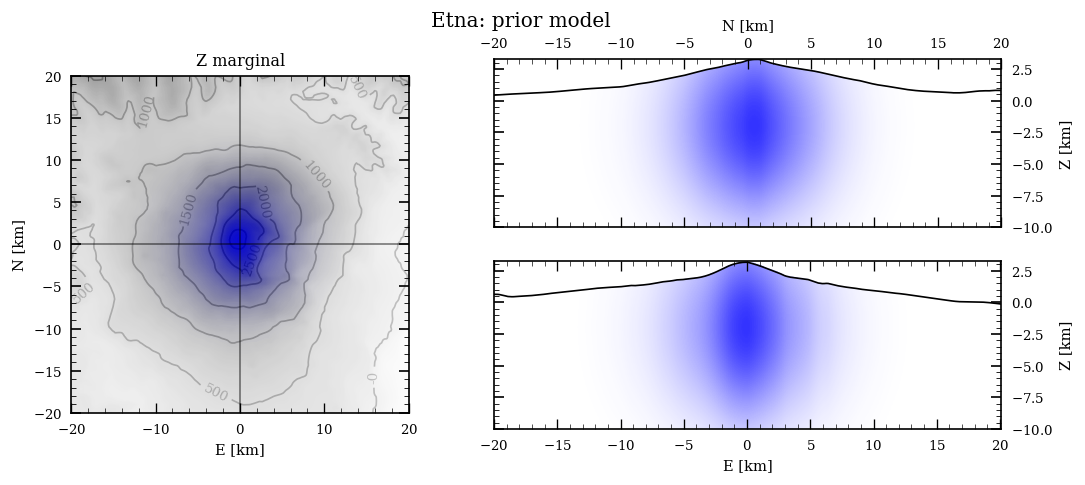

In [18]:
PRIOR_DATA = construct_highly_opinionated_prior(
    SURFACE_DATA, MAX_DEPTH,
    center_location    = (0.0, 0.0, -2.0), # km
    standard_deviation = (5.0, 5.0,  5.0), # km  
    prop2elevation     = True
)

fig, ax_dict = plot_prior_model(PRIOR_DATA, SURFACE_DATA, VOLCANO_DATA)
fig.suptitle(f'{VOLCANO_DATA["Volcano Name"]}: prior model', fontsize=12)

plt.show()

In [19]:
################# Calculate Prior Information ################
from helpers.volcano_data_helpers import calculate_prior_information

prior_information = calculate_prior_information(
    PRIOR_DATA
)
print(f"Prior information: {prior_information:.2f} nats")
# this value in itself is not very informative, but we will make it more informative later on

Prior information: -28.85 nats


# Design Space
When optimising for the best design, we must consider numerous constraints present in each real-world scenario. In our code package, the design space (the set of all locations where a station or array can be placed) is defined on the grid of the (interpolated) DEM, where each cell is assigned a true or false value depending on whether or not a station can be placed there. In this example, we assume that nodal stations can only be placed in areas with an incline of less than 20 degrees, that array stations can be placed in regions with an incline of less than 3 degrees, that no station can be placed below sea level, that there is a safety margin of 3 km around the centre of the volcano if it erupted within the last ten years, and that arrays are placed in areas of at least 10 km$^2$ of flat ($<3$ degrees) area

Having the design space defined by general rules makes it easier to adapt to more complex scenarios with more constraints. Examples might include the use of satellite imagery to avoid recent lava flows, heavily wooded areas, urban areas, areas that are likely to experience high seismic noise, or any other area that is unsuitable for a seismic station. Using a genetic algorithm in the design optimisation process removes the need for constraints to have specific analytical properties, and so also makes it straightforward to include dynamic constraints such as the walking distance between stations, monetary constraints, or any other constraint that can be expressed as a function of the station locations.

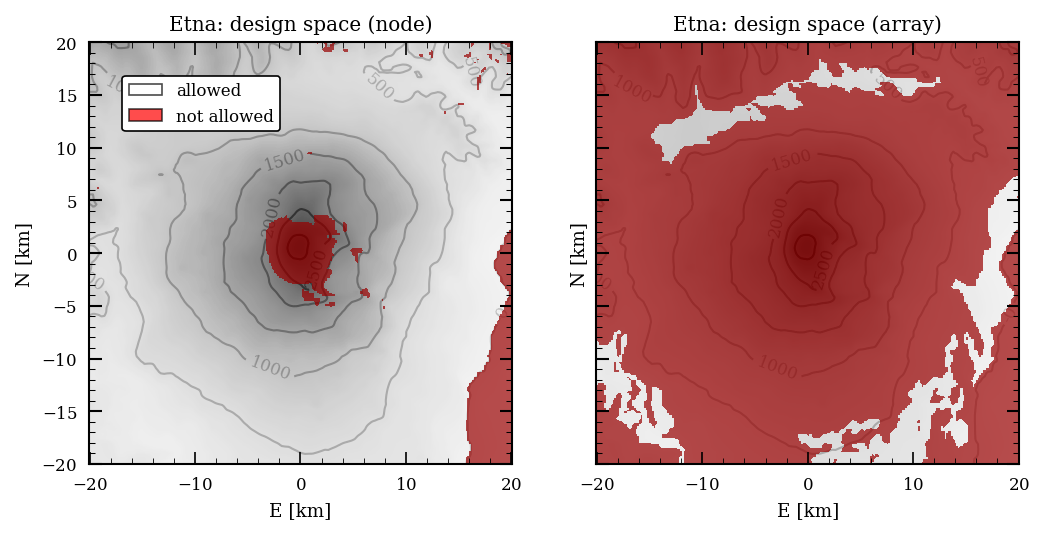

In [20]:
from helpers.design_space_helpers import construct_design_space

design_space_node = construct_design_space(
    SURFACE_DATA,
    max_incline             = 20.0,      # degrees,
    exclude_below_sea_level = True,
    # only add a safety margin if the last eruption was within the last 10 years
    safety_margin           = 3.0 if int(VOLCANO_DATA['Last Eruption Year']) >= time.localtime().tm_year-10 else 0.0, # km
    )

design_space_array = construct_design_space(
    SURFACE_DATA,
    max_incline             = 3.0,         # degrees,
    exclude_below_sea_level = True,
    # only add a safety margin if the last eruption was within the last 10 years
    safety_margin           = 3.0 if int(VOLCANO_DATA['Last Eruption Year']) >= time.localtime().tm_year-10 else 0.0,  # km,
    min_area                = 10           # km^2 minimum area of the connected region
    )

design_space_dict = dict(
    node=design_space_node,
    array=design_space_array,
)   

plot_design_space_dict(design_space_dict, SURFACE_DATA, VOLCANO_DATA);

# Forward Solver

To construct the forward function, we need to define several parameters that govern the propagation of seismic waves in the subsurface, with often limited information available. For travel-time data we set the P-wave velocity to 3.5km/s (Patane et al., 2002) and the corresponding uncertainties $\sigma_t$ to 0.01s and $\sigma_v$ to 0.1 (corresponds to a characteristic standard deviation of the velocity of $10\%$ along the ray path). For amplitude measurments, the quality factor $Q$ is set to 50, the frequency of interest $f$ to 2.0Hz, and the S-wave velocity is set to $v_s = v_p/\sqrt{3}$ (Patane et al., 2002; Morioka et al., 2017;
Kumagai et al., 2009). A literature review, often including other, analogue volcanoes or geologies, is often necessary in order to estimate a suitable quality factor $Q$ and uncertainty for amplitude data. The low computational cost of the $\mathrm{D}_N$ method allows possible values to be tested rapidly, and in our experience, many different combinations of values typically result in similar experimental designs. The standard deviation of the quality factor is set to 10 in this example, and this, together with the uncertainties of the S-wave travel-time and the distance between the source and receiver allows the uncertainty in amplitude to be calculated. The uncertainty in the azimuth is set to 6 degrees (Inza et al., 2011), and the incident angle is not used in this example. The back azimuth measurements require the least prior information. Within the code, the orientation of the array is corrected for the local topography.

---
!!! Warning !!!

By using a homogeneous velocity model, we assume that the geometry of the volcano is a [convex set](https://en.wikipedia.org/wiki/Convex_set) and therefore the straight rays between source and receiver do not intersect the topography. This is typically true on the large scale, but care must be taken when applying this workflow for example in a crater or caldera where the geometry is not a convex set. In this case, the forward solver must be adapted to take the topography into account.


In [21]:
from helpers.forward_function_helpers import Forward_Function

forward_function = Forward_Function({
    'arrival_p': {
        'v_hom'   : 3500.0,  # p-wave velocity of the homogeneous velcoity model [m/s]                                                  
        'std_obs' : 0.01,    # standard deviation due to observational uncertainty
        'std_vel' : 0.1,     # standard deviation due to uncertainty in the velocity model
    },
    'amplitude_s': {
        'v_hom'   : 3500.0/np.sqrt(3),  # s-wave velocity of the homogeneous velcoity model [m/s]
        'std_vel' : 0.1 ,    # standard deviation due to uncertainty in the velocity model
        'f'       : 5.0,     # frequency of interest [Hz]
        'Q'       : 50.0,    # quality factor of the medium
        'std_Q'   : 10.0,    # standard deviation in the quality factor
    },
    'array': {
        'v_hom'   : 3500.0,  # p-wave velocity of the homogeneous velcoity model [m/s]
        'std_baz' : 6.0,     # standard deviation in the backazimuth [degrees]
        # 'std_inc' : 20.0,  # standard deviation in the inclination [degrees]
        'deg_std' : True,    # switch to use standard deviation in degrees
        'baz_only': True,    # switch to only use the backazimuth
        'correct_for_topography': True, # switch to correct for topography
    },},
    surface_data=SURFACE_DATA,
)

# Experimental Design (Design Criterion)

For more information on the design criterions, see the Paper.

In [23]:
from helpers.experimental_design_helpers import (
    DN_method,
    NMC_method)

dn_method = DN_method(
    forward_function,
    PRIOR_DATA,
    n_model_samples=int(1e3)
)

nmc_method = NMC_method(
    forward_function,
    PRIOR_DATA,
    n_model_samples=int(1e3),
)

# Experimental Design (Design Optimisation)

The design optimisation is performed using a genetic algorithm, which is a stochastic optimisation algorithm inspired by the process of natural selection. The algorithm starts with a population of random designs, and then iteratively evolves the population by selecting the best designs, crossing them over, and mutating them. The algorithm is run for a fixed number of generations, and the best design found is returned.

You can choose to provide a preexisting design to which the algorithm will add a optimal subnetwork of stations. This can be useful if you have already deployed some stations and want to add more to improve the network.

In [52]:
# you can easily add already existing stations here to the preexisting_design
#TODO: for now it only works in local coordinates
# from helpers.volcano_data_helpers import get_elevation
# preexisting_design = (
#     (('arrival_p', 'amplitude_s'),
#      np.array(
#      [ 10.0, 10.0,
#       get_elevation(np.array([ 10.0, 10.0,]), SURFACE_DATA)]
#      )*1e3),
# )
# for now we will use no preexisting design
preexisting_design = None

GA progress:   0%|          | 0/500 [00:00<?, ?it/s, EIG=0]

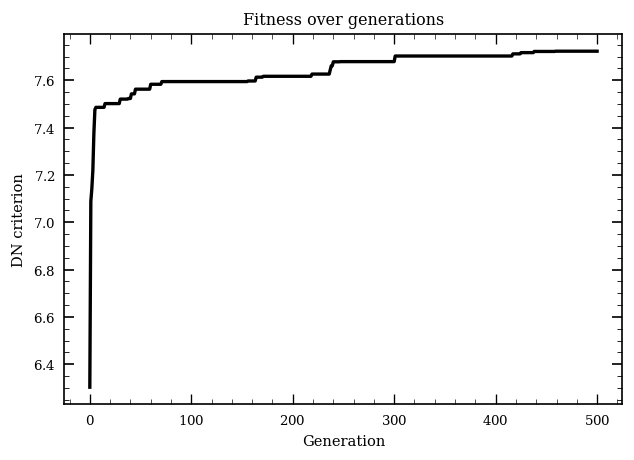

In [64]:
from helpers.experimental_design_helpers import Design_Optimisation

available_stations = dict(
    n_node=3,
    n_array=1)

# alternative way to define the available stations
# available_stations = (
#     ('array', 'arrival_p', amplitude_s'),   
#     ('arrival_p', 'amplitude_s'),
#     ('arrival_p', 'amplitude_s'),
#     ('arrival_p', 'amplitude_s'))

design_optimisation = Design_Optimisation(
    dn_method,
    SURFACE_DATA,
    design_space_dict,
    preexisting_design=preexisting_design
)

best_design, info = design_optimisation.get_optimal_design(
    available_stations=available_stations,
        optimisation_algorithm='genetic',
        optimisation_kwargs=dict(
            num_generations=100, # set to 100 for first quick results, set to between 500 and 1000 for more accurate results    
            num_parents_mating=4,
            plot_fitness=True,
            random_seed=0,
        )
)

In [69]:
from helpers.plotting_helpers import interactive_design_plot

fig, updated_design, synthetic_true_model = interactive_design_plot(
    original_design   = best_design,
    volcano_data      = VOLCANO_DATA,
    surface_data      = SURFACE_DATA,
    prior_data        = PRIOR_DATA,
    design_space_dict = design_space_dict,
    eig_criterion     = nmc_method,
    prior_information = prior_information,
    forward_function  = forward_function,
    posterior         = True,
)

# ======================== INTERACTIVE PLOT ========================

# The plot above shows the optimal design. You can interact with it by moving the stations or the test source location around.
# The design is updated in real time and the design statistics are shown in the top right corner.

# ======================== Careful: ========================
# The design statistics might update with a delay, especially on an older computer or if running in google colab.
# When changing the design to quick the statistics might not update at all. Just reset by running the cell again.
# If a smooth experience is needed, run the code locally in a jupyter notebook. On my laptop the process is smooth and the statistics update in near real time.

# Sometimes it does not quite work and you have to run the cell again, change the design and then run the next cell manually.

display(fig)

In [66]:
# make below cell work if interactive plot is not used
try:
    updated_design
except NameError:
    updated_design = best_design

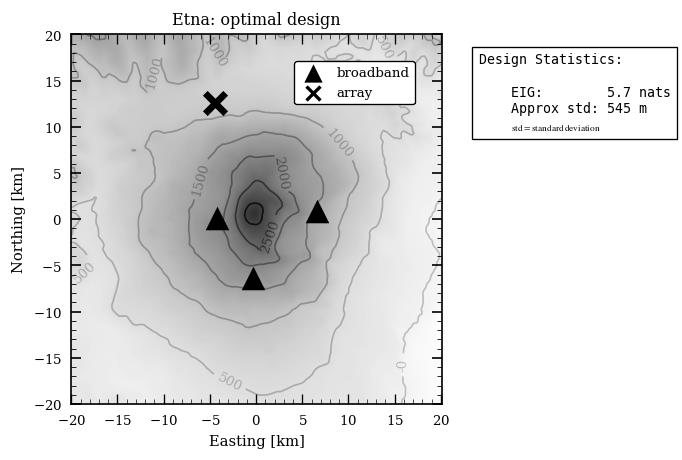

In [67]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=120)

plot_topography(ax, SURFACE_DATA['topography'])
plot_design(ax, best_design)
eig, approx_std = plot_design_statistics(ax, best_design, nmc_method, prior_information)

ax.set_title(f'{VOLCANO_NAME}: optimal design')

plt.show()

True model: 
    E: 1000.00 m,
    N: -1000.00 m,
    Z: -1000.00 m

Posterior Mode:          Posterior Mean:          Posterior Std:
    E:     837.73 m 		 E:     990.96 m 		 E:     302.26 m 
    N:   -1102.27 m 		 N:    -962.69 m 		 N:     365.12 m
    Z:   -1026.36 m 		 Z:    -830.22 m 		 Z:     707.72 m
    


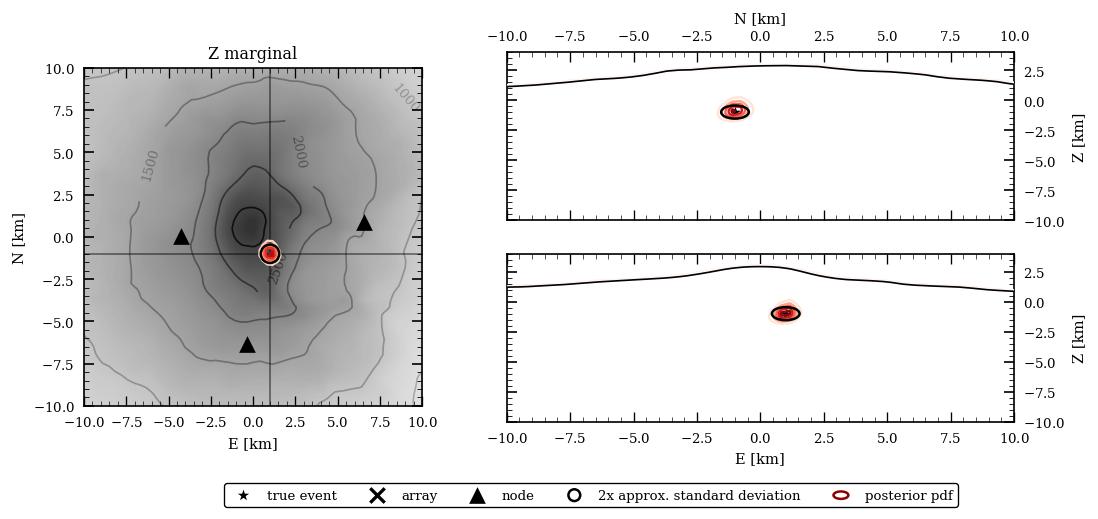

In [68]:
from helpers.posterior_helpers import (
    calculate_posterior,
    get_posterior_statistics,
    display_posterior_statistics)

synthetic_true_model = np.array([1.0, -1.0, -1.0])*1e3
        
test_prior, test_posterior = calculate_posterior(
    updated_design,
    synthetic_true_model,
    PRIOR_DATA,
    forward_function,
)

print(f'''True model: 
    E: {synthetic_true_model[0]:.2f} m,
    N: {synthetic_true_model[1]:.2f} m,
    Z: {synthetic_true_model[2]:.2f} m''')

print(display_posterior_statistics(*get_posterior_statistics(test_posterior)))
        
plot_posterior_model(
    updated_design, test_posterior, SURFACE_DATA,
    synthetic_true_model,
    E_lim = (-10.0, 10.0),
    N_lim = (-10.0, 10.0),
    Z_lim = (-10.0,  4.0),
    std=approx_std);